In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

## Create the folder creation code 

In [2]:
#Sset project dir, create folders, save & verify

from pathlib import Path
import os

# 1)  Set your actual project folder here (ABSOLUTE path)
PROJECT_DIR = Path(r"C:\Users\ameer\Houseprice-project")  # <-- change if needed

# 2) Create folders and switch there so all relative paths are stable
for sub in ["data", "dashboard", "notebook"]:
    (PROJECT_DIR / sub).mkdir(parents=True, exist_ok=True)

os.chdir(PROJECT_DIR)  # now "dashboard/..." means this folder for sure
print("📂 CWD set to:", Path.cwd())
print("📁 Subfolders exist:", *(p.name for p in PROJECT_DIR.iterdir() if p.is_dir()), sep="\n  - ")

# 3) Helper to save and confirm
def save_csv(df, rel_path):
    out_path = PROJECT_DIR / rel_path
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_path, index=False)
    print(f"✅ Saved: {out_path}  |  Exists? {out_path.exists()}")



# 4) List what's inside dashboard
dash_files = list((PROJECT_DIR / "dashboard").glob("*"))
print("📦 dashboard contents:", [f.name for f in dash_files])


📂 CWD set to: C:\Users\ameer\Houseprice-project
📁 Subfolders exist:
  - .ipynb_checkpoints
  - dashboard
  - data
  - notebook
📦 dashboard contents: ['feature_importance.csv', 'HousePriceDashboard.pbix', 'predictions_validation.csv']


In [3]:
train = pd.read_csv(r"C:\Users\ameer\Houseprice-project\data\train.csv")
print("Rows, Cols:", train.shape)

Rows, Cols: (1460, 81)


## numeric heatmap

Id               int64
MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
dtype: object
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
GarageType        81
GarageQual        81
GarageCond        81
GarageFinish      81
dtype: int64


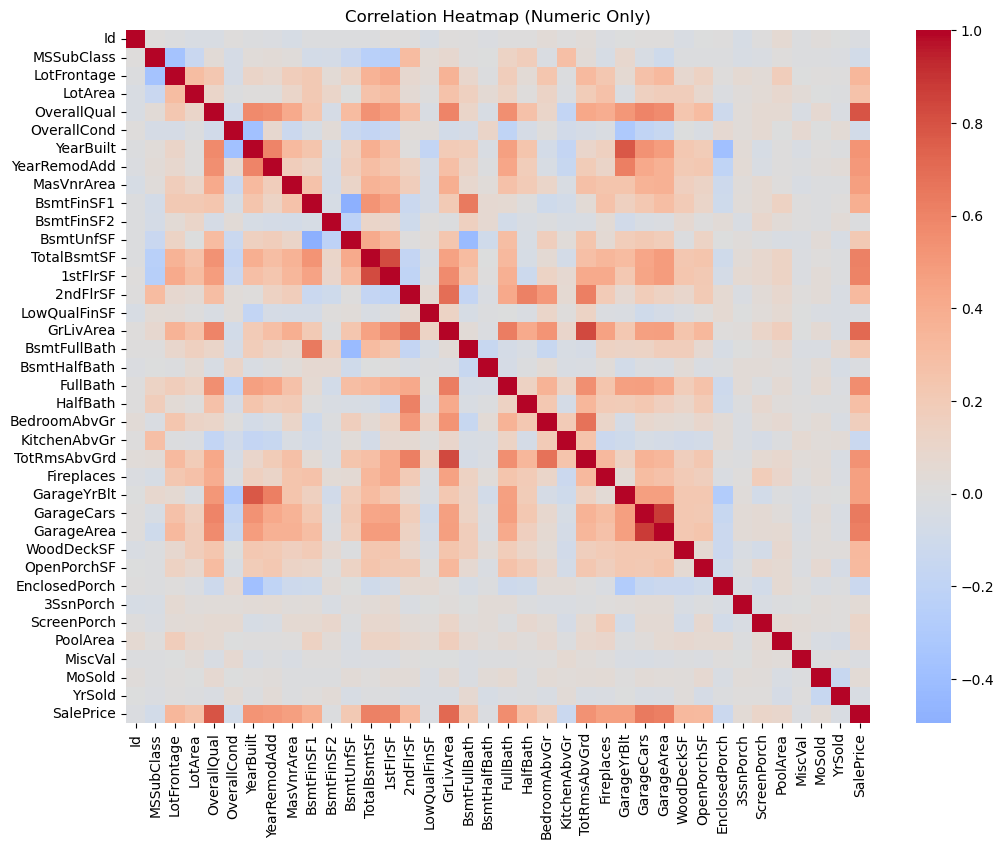

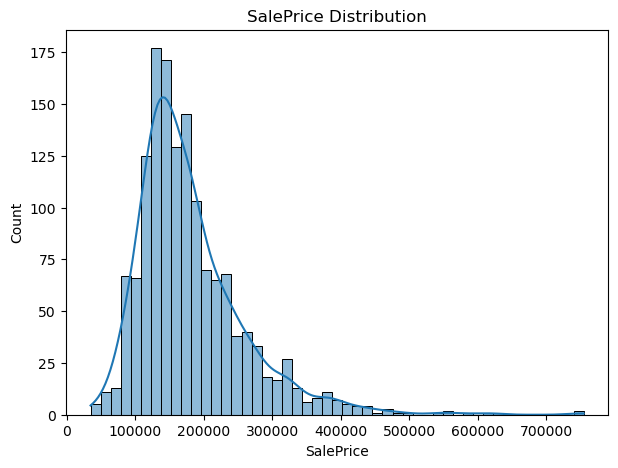

0    5110
1    2371
dtype: int64


In [6]:
# Data Overview
print(train.dtypes.head())
print(train.isna().sum().sort_values(ascending=False).head(10))

# Safe numeric-only corr (avoid 'could not convert string to float' errors)
num_cols_all = train.select_dtypes(include=[np.number]).columns
train[num_cols_all] = train[num_cols_all].fillna(train[num_cols_all].median())

plt.figure(figsize=(12,9))
sns.heatmap(train[num_cols_all].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Only)")
plt.show()

# Distribution of SalePrice
plt.figure(figsize=(7,5))
sns.histplot(train["SalePrice"], kde=True)
plt.title("SalePrice Distribution")
plt.show()

#Show how many missing value are in every 1000 row
# Count total missing values for every 1000 rows
missing_counts = train.isna().groupby(train.index // 1000).sum().sum(axis=1)

print(missing_counts)

## Feature prepping

In [84]:
# Drop Id ONLY if it exists (prevents KeyError: 'Id' not found)
if "Id" in train.columns:
    train = train.drop(columns=["Id"])

# Target in LOG space (prevents overflow later)
y_log = np.log1p(train["SalePrice"])
X = train.drop(columns=["SalePrice"])

from sklearn.model_selection import train_test_split
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# Preprocessing: imputers for NaNs; OHE for cats; scaler (harmless for trees)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])


## Machine Learning models

In [85]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

#  Strong, built-in baseline (no extra install)
hgb_model = Pipeline([
    ("pre", pre),
    ("hgb", HistGradientBoostingRegressor(random_state=42))
])
hgb_model.fit(X_train, y_train_log)
preds_hgb_log = hgb_model.predict(X_val)

# Try XGBoost if available; otherwise keep HGB
use_xgb = False
try:
    from xgboost import XGBRegressor
    xgb_model = Pipeline([
        ("pre", pre),
        ("xgb", XGBRegressor(
            n_estimators=1000,
            learning_rate=0.03,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            tree_method="hist"
        ))
    ])
    xgb_model.fit(X_train, y_train_log)
    preds_xgb_log = xgb_model.predict(X_val)
    use_xgb = True
except ModuleNotFoundError:
    print(" Xgboost not installed — sticking with HistGradientBoosting. In notebook: !pip install xgboost")

# Choose best by log-RMSE
def eval_log_rmse(y_true_log, y_pred_log):
    return mean_squared_error(y_true_log, y_pred_log, squared=False)

rmse_hgb_log = eval_log_rmse(y_val_log, preds_hgb_log)
best_model = hgb_model
best_preds_log = preds_hgb_log
best_name = "HistGradientBoosting"

if use_xgb:
    rmse_xgb_log = eval_log_rmse(y_val_log, preds_xgb_log)
    if rmse_xgb_log < rmse_hgb_log:
        best_model = xgb_model
        best_preds_log = preds_xgb_log
        best_name = "XGBoost"

print(f" Best model: {best_name}")
print(" RMSE (log space):", eval_log_rmse(y_val_log, best_preds_log))

# Price-space metrics (NO overflow: log target is sane ~10–14)
preds_price = np.expm1(best_preds_log)
true_price  = np.expm1(y_val_log)
rmse_price  = mean_squared_error(true_price, preds_price, squared=False)
print("✅ RMSE (price space):", rmse_price)


✅ Best model: XGBoost
✅ RMSE (log space): 0.13569675002413611
✅ RMSE (price space): 25341.765532582325


## Exaplinability and exports

In [86]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

# Refit best model to ensure alignment
best_model.fit(X_train, y_train_log)

# Get post-OHE feature names from the pipeline
ohe = best_model.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
num_feature_names = np.array(num_cols)
feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Permutation importance on transformed validation data
X_val_trans = best_model.named_steps["pre"].transform(X_val)
core_name = [k for k in best_model.named_steps.keys() if k not in ("pre",)][0]
core_model = best_model.named_steps[core_name]

imp = permutation_importance(
    core_model, X_val_trans, y_val_log, n_repeats=10, random_state=42, scoring="neg_root_mean_squared_error"
)
imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": imp.importances_mean
}).sort_values("Importance", ascending=False)

# Exports (folders already exist)
imp_df.to_csv("dashboard/feature_importance.csv", index=False)

val_out = X_val.copy()
val_out["ActualPrice"] = true_price
val_out["PredictedPrice"] = preds_price
val_out["Residual"] = val_out["ActualPrice"] - val_out["PredictedPrice"]
val_out.to_csv("dashboard/predictions_validation.csv", index=False)

print("📦 Saved: dashboard/feature_importance.csv")
print("📦 Saved: dashboard/predictions_validation.csv")


📦 Saved: dashboard/feature_importance.csv
📦 Saved: dashboard/predictions_validation.csv
